# Temperature Power Spectrum

## import package

In [127]:
import sys
import numpy as np
import joblib as jl

from matplotlib import pyplot as plt

sys.path.append('/home/b11209013/Package/')
import Theory as th
import DataProcess as dp
import SignalProcess as sp

## Load data

In [128]:
case: str = 'NSC'

if case == 'CNTL':
    t_scale: float = 7.42
elif case == 'NCRF':
    t_scale: float = 6.39
elif case == 'NSC':
    t_scale: float = 4.44

fname: str = f'/work/b11209013/2024_Research/MPAS/PC/{case}_PC.joblib'

data: dict[str] = jl.load(fname)

lon: np.ndarray = data['lon']
lat: np.ndarray = data['lat']

pc: dict[str] = {
    'tpc1': data['pc1']['t'],
    'tpc2': data['pc2']['t']
}
var_list= pc.keys()

## Processing data

### Symmetric

In [129]:
fmt = dp.Format(lat)

sym: dict[str] = {
    var: fmt.sym(pc[var])
    for var in var_list
}
asy: dict[str] = {
    var: fmt.asy(pc[var])
    for var in var_list
}

### Windowing

In [130]:
Hann_windowing = np.hanning(120)[:, None]

sym_hann = {
    var: np.array([
        sym[var][i*60:i*60+120] * Hann_windowing
        for i in range(5)
        ])
    for var in var_list
}

asy_hann = {
    var: np.array([
        asy[var][i*60:i*60+120] * Hann_windowing
        for i in range(5)
        ])
    for var in var_list
}

## Compute Power Spectrum

### Compute Raw Spectrum

In [131]:
ft = sp.Fourier()

sym_ps = {
    var: np.array([
        ft.PowerSpectrum(sym_hann[var][i])
        for i in range(sym_hann[var].shape[0])
    ]).mean(axis=0)
    for var in var_list
}

asy_ps = {
    var: np.array([
        ft.PowerSpectrum(asy_hann[var][i])
        for i in range(asy_hann[var].shape[0])
    ]).mean(axis=0)
    for var in var_list
}

print(sym_ps.keys())

dict_keys(['tpc1', 'tpc2'])


### Compute Peak

In [132]:
def background(sym, asy, cr=10):
    ave = (sym + asy) / 2

    low = dp.GaussianFilter(ave[:cr], 40)
    high = dp.GaussianFilter(ave[cr:], 10)

    space_filt = np.concatenate([low, high], axis=0).T

    bg = dp.GaussianFilter(space_filt, 10).T

    return bg

sym_peak = {}
    
for key in sym_ps.keys():

    bg = background(sym_ps[key], asy_ps[key], 15)
    sym_peak[key] = sym_ps[key] / bg

print(sym_peak.keys())

dict_keys(['tpc1', 'tpc2'])


## Dominant frequency

In [133]:
wn = np.linspace(-359, 360, 720)
fr = np.linspace(1/30, 2, 60)

wnm, frm = np.meshgrid(wn, fr)

kel_curves = lambda ed, k: (86400/(2*np.pi*6.371e6))*np.sqrt(9.81*ed)*k

cond = (
    (wnm >= 1) & (wnm < 14) &
    (frm >= 1/20) & (frm <= 1/2.5) &
    (frm <= kel_curves(90, wnm)) & (frm >= kel_curves(8, wnm))
)

pc1_var = np.where(cond, sym_ps['tpc1'], np.nan)
pc2_var = np.where(cond, sym_ps['tpc2'], np.nan)

pc1_freq = (frm * pc1_var) / np.nansum(pc1_var)
pc2_freq = (frm * pc2_var) / np.nansum(pc2_var)

pc1_dom_freq = frm[np.where(pc1_freq == np.nanmax(pc1_freq))]
pc2_dom_freq = frm[np.where(pc2_freq == np.nanmax(pc2_freq))]

print('pc1 dominate frequency: ', pc1_dom_freq)
print('pc2 dominate frequency: ', pc2_dom_freq)

pc1 dominate frequency:  [0.16666667]
pc2 dominate frequency:  [0.2]


## Plot Power Spectrum Diagram

### Plot setting

In [134]:
plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'font.family': 'serif',
})

fr_ana, wn_ana = th.genDispersionCurves(Ahe=[90, 25, 8])

e_cond = np.where(wn_ana[3, 0, :] < 0)[0]

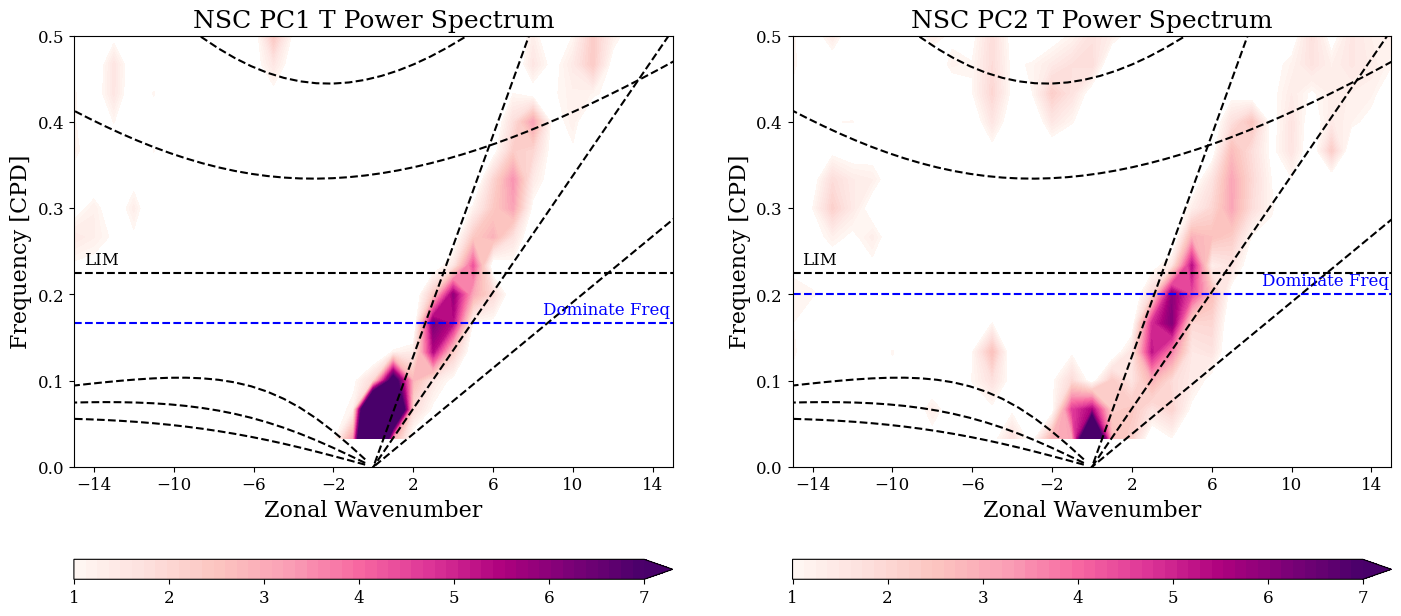

In [135]:

fig, ax = plt.subplots(1, 2, figsize=(17, 8))
c1 = ax[0].contourf(
    wnm, frm, 
    sym_peak['tpc1'],
    levels=np.linspace(1, 7),
    cmap="RdPu",
    extend='max'
)
ax[0].axhline(1/t_scale, linestyle='--', color='k')
ax[0].axhline(pc1_dom_freq, linestyle='--', color='b')
for i in range(3):
    ax[0].plot(wn_ana[3, i, e_cond], fr_ana[3, i, e_cond], 'k--')
    ax[0].plot(wn_ana[4, i, :], fr_ana[4, i, :], 'k--')
    ax[0].plot(wn_ana[5, i, :], fr_ana[5, i, :], 'k--')
ax[0].text(-14.5, 1/t_scale+0.01, 'LIM')
ax[0].text(8.5, pc1_dom_freq+0.01, 'Dominate Freq', color='b')
ax[0].set_xticks(np.linspace(-14, 14, 8))
ax[0].set_yticks(np.linspace(0, 0.5, 6))
ax[0].set_xlim(-15, 15)
ax[0].set_ylim(0, 0.5)
ax[0].set_xlabel('Zonal Wavenumber')
ax[0].set_ylabel('Frequency [CPD]')
ax[0].set_title(f'{case} PC1 T Power Spectrum')
cbar1 = plt.colorbar(
    c1,
    ax=ax[0],
    aspect=30,
    orientation='horizontal'
)
cbar1.set_ticks(np.linspace(1, 7, 7))

c2 = ax[1].contourf(
    wnm, frm, 
    sym_peak['tpc2'],
    levels=np.linspace(1, 7),
    cmap="RdPu",
    extend='max'
)
ax[1].axhline(1/t_scale, linestyle='--', color='k')
ax[1].axhline(pc2_dom_freq, linestyle='--', color='b')
for i in range(3):
    ax[1].plot(wn_ana[3, i, e_cond], fr_ana[3, i, e_cond], 'k--')
    ax[1].plot(wn_ana[4, i, :], fr_ana[4, i, :], 'k--')
    ax[1].plot(wn_ana[5, i, :], fr_ana[5, i, :], 'k--')
ax[1].text(-14.5, 1/t_scale+0.01, 'LIM')
ax[1].text(8.5, pc2_dom_freq+0.01, 'Dominate Freq', color='b')
ax[1].set_xticks(np.linspace(-14, 14, 8))
ax[1].set_yticks(np.linspace(0, 0.5, 6))
ax[1].set_xlim(-15, 15)
ax[1].set_ylim(0, 0.5)
ax[1].set_xlabel('Zonal Wavenumber')
ax[1].set_ylabel('Frequency [CPD]')
ax[1].set_title(f'{case} PC2 T Power Spectrum')
cbar2 = plt.colorbar(
    c2,
    ax=ax[1],
    aspect=30,
    orientation='horizontal'
)
cbar2.set_ticks(np.linspace(1, 7, 7))
plt.savefig(f'{case}_t_ps.png')